# Gaussian Processes, step by step
To better understand Gaussian Processes, we'll study it's posterior predictions for increasingly large samples of data. As input data, we consider real data about solar radiation measured by a weather balloon:
https://www.openml.org/d/512. We'll use only the raw data (at least the first 1500 points) and try to learn the (very noisy) trend. 

In [1]:
# General imports
%matplotlib inline
from preamble import *
plt.rcParams['figure.dpi'] = 100

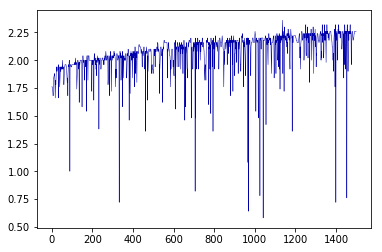

In [3]:
# Get the data from OpenML
balloon_data = oml.datasets.get_dataset(512) # Download Balloon data
X, y = balloon_data.get_data(target=balloon_data.default_target_attribute);

# Use the first 1000 points for training, and the next 500 for testing
train = X[:1000]
test = X[1000:1500]
X_train = np.array(list(range(1000)))[np.newaxis].T
y_train = X[:1000].reshape(-1, 1)
X_test = np.array(list(range(1000,1500)))[np.newaxis].T
y_test = X[1000:1500].reshape(-1, 1)
X_all = np.array(list(range(1500)))[np.newaxis].T

pd.Series(X[:1500,0]).plot();

## Bayesian updates
Starting with the humble RBF kernel, `RBF(10, (1e-2, 1e2))`, we look at the posterior as we train the GP with 10 random data points at a time. Results are plotted below:

In [4]:
# Randomized permutations. 
# Making sure that the labels are shuffled in the same way as the data points.
p = np.random.permutation(len(X_train))
X_train_perm=X_train[p]
y_train_perm=y_train[p]

p = np.random.permutation(len(X_test))
X_test_perm=p
y_test_perm=y_test[p]

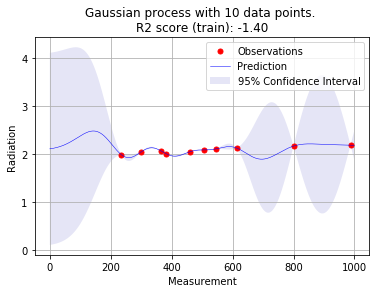

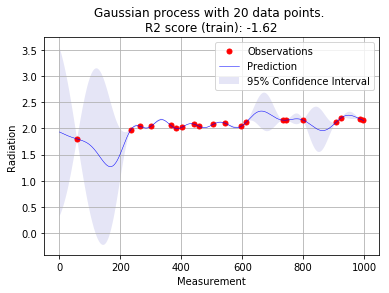

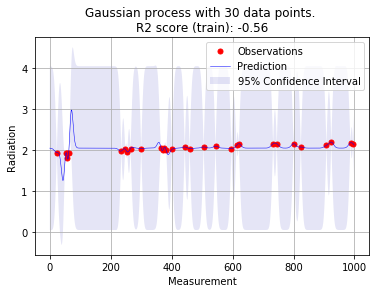

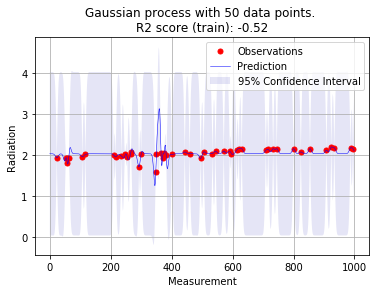

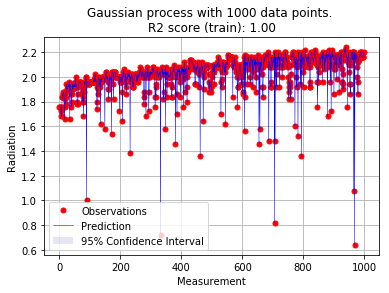

In [13]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Instanciate a Gaussian Process model
kernel = RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=0, normalize_y=True) 

for end in [10,20,30,50,len(X_train)]:
    # Fit to data using Maximum Likelihood Estimation of the parameters
    _=gp.fit(X_train_perm[:end], y_train_perm[:end].ravel())

    # Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pred, sigma = gp.predict(X_train, return_std=True)
    
    # Plot the function, the prediction and the 95% confidence interval based on
    # the MSE
    fig = plt.figure();
    _=plt.plot(X_train_perm[:end], y_train_perm[:end], 'r.', markersize=10, label=u'Observations');
    _=plt.plot(X_train, y_pred, 'b-', label=u'Prediction');
    _=plt.fill_between(X_train.ravel(),y_pred-2*sigma,y_pred+2*sigma,label='95% Confidence Interval',alpha=0.1);
    _=plt.xlabel('Measurement');
    _=plt.ylabel('Radiation');
    _=plt.title('Gaussian process with '+str(end)+' data points. \n'+
                'R2 score (train): {:.2f}'.format(gp.score(X_train, y_train)))
    _=plt.grid();
    _=plt.legend(loc='best');

We can see that the GP interpolates the data points nicely. At the same time, it is clearly overfitting.

## Extrapolation and evaluation
We will now train the GP on the complete dataset and evaluate how well it can extrapolate to future data points. We will also need to tune the hyperparameters.

In [26]:
# Visualize the predictions
def plot_gp(kernel, alpha=0):
    # Train
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=9, normalize_y=True)
    gp.fit(X_train, y_train);
    
    # Predict
    y_pred, sigma = gp.predict(X_all, return_std=True)
    
    # Plot the function, the prediction and the 95% confidence interval
    fig = plt.figure(figsize=(8,6))
    plt.plot(X_train, y_train, 'r.', markersize=10, label=u'Observations')
    plt.plot(X_test, y_test, 'g.', markersize=10, label=u'Target')
    plt.plot(X_all, y_pred, 'b-', label=u'Prediction')
    plt.fill_between(X_all.ravel(),y_pred.ravel()-2*sigma,y_pred.ravel()+2*sigma,
                     label='95% Confidence Interval',alpha=0.1)
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.legend(loc='bottom right')
    plt.title('{}, alpha:{} - R2: {}'.format(gp.kernel_,alpha,gp.score(X_test, y_test)))    

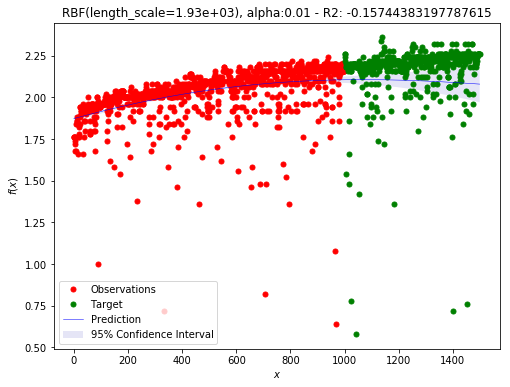

In [27]:
kernel = RBF(10, (1e-4, 1e4))
plot_gp(kernel, alpha=0.01)

* The GP overfits very easily, and the default RBF kernel does not extrapolate much better than an (almost) GP obtained by high regularization.

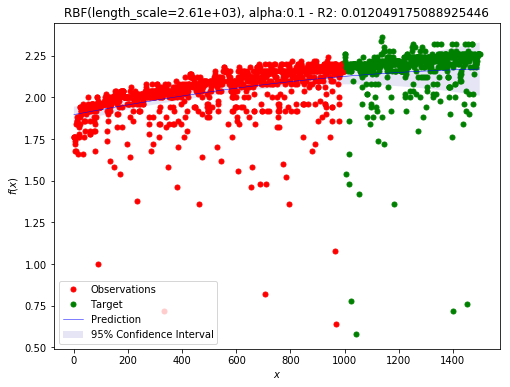

In [45]:
kernel = RBF(10, (1e-4, 1e4))
plot_gp(kernel, alpha=0.1)

The main problem is that Gaussian Processes assume that noise is normally distributed, which it clearly is not in this case. There exist more robust generalizations of GP's, e.g. using Student-t likelihood, but these are not supported by SKlearn (try GPy instead).